In [1]:
import torch
import numpy as np
import glob
import os
import random
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from torch import nn
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset_dir = 'yeast_processed_norm_area_50'
model_dir = 'unet2D_aug_norm'

used some code from: https://github.com/seyma-tas/Brain-Tumor-Segmentation-Project/blob/master/2AdamW_DICE_BrainTumorGenesis.ipynb
also used: https://github.com/MrGiovanni/ModelsGenesis

# Accuracy and Loss Metrics

In [2]:
def dice_metric(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    
    intersection = 2.0 * (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2)
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

def jaccard_index(inputs, target):
    num = target.shape[0]
    chans = target.shape[1]
    inputs = inputs.reshape(num, chans, -1)
    target = target.reshape(num, chans, -1)
    
    intersection = (target * inputs).sum(2)
    union = target.sum(2) + inputs.sum(2) - intersection
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return (intersection / union).mean()

# def dice_loss(inputs, target):
#     num = target.size(0)
#     chans = target.size(1)
#     inputs = inputs.reshape(num*chans, -1)
#     target = target.reshape(num*chans, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / (num*chans)
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# Model
From https://github.com/MrGiovanni/ModelsGenesis

In [3]:


class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))
        #super(ContBatchNorm3d, self)._check_input_dim(input)

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)


class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out


def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, n_class=1, n_channels=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(n_channels,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512, 512,2,act)
        self.up_tr128 = UpTransition(256,256, 1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64, n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256, self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128, self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out



# Load and define dataset


In [4]:
class DatasetSegmentation(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, transform = None, normalize_transform = None, interp_size = 512):
        super(DatasetSegmentation, self).__init__()
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.compose([
                transforms.Resize((interp_size, interp_size), interpolation=0)
            ])
            
        if normalize_transform:
            self.normalize_transform = normalize_transform
        else:
            self.normalize_transform = None
        
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(os.path.join(folder_path, 'masks', os.path.basename(img_path)) )

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)
        
        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        
        samp = torch.cat((data, label))
        
        samp = self.transform(samp)
        data = samp[:-1]
        label = samp[-1].unsqueeze(0)
        
        if self.normalize_transform:
            data = self.normalize_transform(data)
            

#         data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
#         label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label

    def __len__(self):
        return len(self.img_files)

In [5]:
import json

with open(os.path.join('data', dataset_dir, 'stds.json'), 'r') as f:
    stds = json.load(f)
    
stds

[[0.025770969688892365,
  0.2516340911388397,
  0.000478560192277655,
  0.11163000762462616],
 [0.02316989190876484,
  0.22105874121189117,
  0.0031911141704767942,
  0.1474960595369339]]

In [6]:
normalize_transform = transforms.Normalize(
                                    stds[0],
                                    stds[1])


class RandomTranspose(object):
    """Randomly transpose sample
    """

    def __call__(self, sample):
        transpose = random.random() < 0.5
        if transpose:
            # sample is CxHxW
            return torch.transpose(sample, -1, -2)
        else:
            return sample


transform_dict = {'train': transforms.Compose([
                transforms.Resize((512,512), interpolation=0),
                RandomTranspose(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
            ]),
             'val': transforms.Compose([
                transforms.Resize((512,512), interpolation=0),
            ])}

ds_train = DatasetSegmentation(os.path.join('data', dataset_dir, 'train'), transform=transform_dict['train'], normalize_transform=normalize_transform)
ds_test = DatasetSegmentation(os.path.join('data', dataset_dir, 'test'), transform=transform_dict['val'], normalize_transform=normalize_transform)
ds_val = DatasetSegmentation(os.path.join('data', dataset_dir, 'val'), transform=transform_dict['val'], normalize_transform=normalize_transform)

In [7]:
ds_train.__len__(), ds_test.__len__()

(892, 111)

In [8]:
sample = ds_train.__getitem__(12)

In [9]:
sample[1].shape

torch.Size([1, 512, 512])

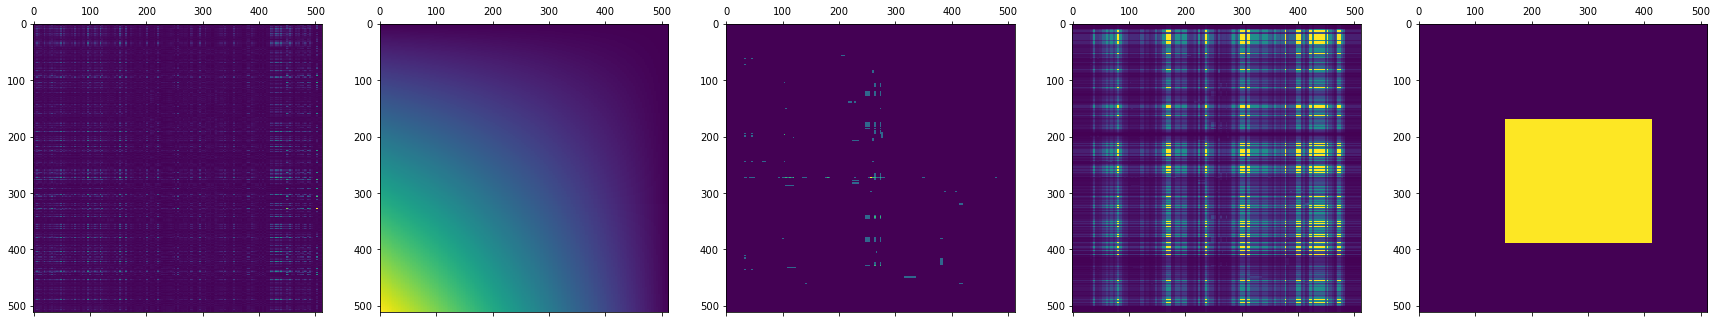

In [10]:
fig, axs = plt.subplots(1,5, figsize=(30,30))
axs[0].matshow(sample[0][0].view(512,512))
axs[1].matshow(sample[0][1].view(512,512))
axs[2].matshow(sample[0][2].view(512,512))
axs[3].matshow(sample[0][3].view(512,512))
axs[4].matshow(sample[1][0].view(512,512))
plt.show()

In [11]:
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=2, num_workers=0, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=2, num_workers=0, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(ds_val, batch_size=2, num_workers=0, shuffle=False)

# Setup Model 

In [12]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])

## Parameters
Setup loss function:

In [13]:
# def dice_metric(inputs, target):
#     intersection = 2.0 * (target * inputs).sum()
#     union = target.sum() + inputs.sum()
#     if target.sum() == 0 and inputs.sum() == 0:
#         return 1.0

#     return intersection / union

# def dice_loss(inputs, target):
#     num = target.size(0)
#     inputs = inputs.reshape(num, -1)
#     target = target.reshape(num, -1)
#     smooth = 1.0
#     intersection = (inputs * target)
#     dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / num
#     return dice

# def bce_dice_loss(inputs, target):
#     dicescore = dice_loss(inputs, target)
#     bcescore = nn.BCELoss()
#     bceloss = bcescore(inputs, target)

#     return bceloss + dicescore

criterion = bce_dice_loss

Setup optimizer

In [14]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=0.1)

In [15]:
from torch.optim import lr_scheduler 
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Prepare Training

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Train

Start train...


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch:   0%|          | 0/446 [00:00<?, ?it/s]

epoch 0 train loss 1.322015010989835 val loss 1.3030091736997877
epoch 1 train loss 1.3103549124948648 val loss 1.3021982248340334
epoch 2 train loss 1.3116066463859626 val loss 1.3055450511830193
epoch 3 train loss 1.310348608034074 val loss 1.3013944051095419
epoch 4 train loss 1.3129834516700607 val loss 1.3018456548452377
epoch 5 train loss 1.3097167939883176 val loss 1.301842866199357
epoch 6 train loss 1.310478120908609 val loss 1.3035869023629598
epoch 7 train loss 1.310446849852934 val loss 1.3018516536269868
epoch 8 train loss 1.2788366536388482 val loss 1.266498299581664
epoch 9 train loss 1.2667351915697347 val loss 1.2596794877733504
epoch 10 train loss 1.2453977660747921 val loss 1.2347456025225776
epoch 11 train loss 1.246199353393418 val loss 1.2342967242002487
epoch 12 train loss 1.2447544282861889 val loss 1.2295311178479875
epoch 13 train loss 1.240590083224891 val loss 1.2366883882454462
epoch 14 train loss 1.2429811783435634 val loss 1.2284439099686486
epoch 15 trai

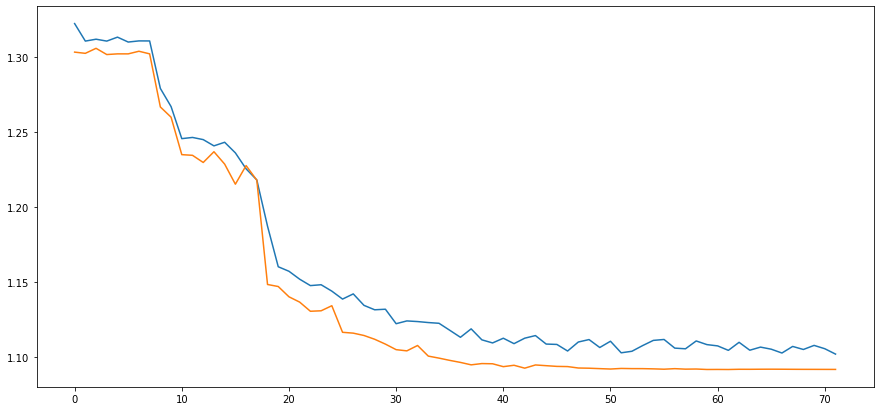

In [17]:
from tqdm.autonotebook import tqdm

if not os.path.isdir(f'./models/{model_dir}/'):
    os.mkdir(f'./models/{model_dir}/')
if not os.path.isdir(f'./models/{model_dir}/{dataset_dir}/'):
    os.mkdir(f'./models/{model_dir}/{dataset_dir}/')

epochs = 1000
min_epochs = 20
early_stop_crit = 10

model.to(device)

# Initialize lists to store loss values
loss_history = []
loss_history_val = []

best_loss_val = float('inf')


early_stop_count = 0
# Train
print("Start train...")
outer = tqdm(total=epochs, desc='Epochs', position=0)
inner = tqdm(total=len(train_dataloader), desc=f'Batch', position=1)
for epoch in range(epochs):
    # check to see if validation loss has plateau'd
    if early_stop_count >= early_stop_crit and epochs > min_epochs:
        print(f'Validation loss plateaud; failed to improve after {early_stop_count} at {epoch}th epoch')
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/{model_dir}/{dataset_dir}/checkpt_earlystop_{epoch}.pth')
        break
    
    early_stop_count += 1
    
   #Train mode
    model.train()
    loss_running = []
    
    inner.refresh()  #force print final state
    inner.reset()  #reuse bar    
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        inner.update(1)
        
    loss_history.append(np.mean(loss_running))
    # Evaluate mode
    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)
    
    # Change the learning rate
    scheduler.step()
    
    # Save the best weights
    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/{model_dir}/{dataset_dir}/best_model.pth')
        early_stop_count = 0
    
    # Save checkpoint every 10
    if epoch % 10 == 0 or epoch >= epochs-1:
        checkpoint = { 
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler}
        torch.save(checkpoint, f'./models/{model_dir}/{dataset_dir}/checkpt{epoch}.pth')
        
    # Print the results    
    outer.update(1)
    print("epoch", epoch, "train loss", loss_history[-1], "val loss", loss_history_val[-1])


# Print loss history
plt.figure(figsize=(15, 7))
plt.plot(loss_history)
plt.plot(loss_history_val)

# Evaluate

In [17]:
checkpoint = torch.load(f'./models/{model_dir}/{dataset_dir}/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

In [18]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask.sum(0))
#     cumsum_a = np.cumsum(mask.sum(1))
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1.0-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1.0-tail), side='left'))
#     return range_a, range_b
from scipy import ndimage

def mask_to_box_many(a, max_label=0):
    labels, n = ndimage.measurements.label(a, np.ones((3, 3)))
              
    if max_label < n:
                    
        # find largest contiguous areas
        # print(n)
        uniques, counts = np.unique(labels, return_counts=True)
        # print(max_label)
        # print(counts)
        ind = np.argpartition(counts, -(max_label+1))[-(max_label+1):] # find indices of top max_label counts; +1 because 0 will be one of them
        # print(ind)
        
        top_uniques = uniques[ind]
        top_counts = counts[ind]
        
        # remove 0
        if 0 in top_uniques:
            rm_i = np.where(top_uniques == 0)
        else:
            # we have 1 too many, remove smallest value
            rm_i = np.argmin(top_counts)
            
        top_counts = np.delete(top_counts, rm_i)
        top_uniques = np.delete(top_uniques, rm_i)
        
#         print(top_uniques)
#         print(top_counts)
#         print(type(top_uniques))
#         print(np.vectorize(lambda label: label in top_uniques)(labels))
        
        # zero out anything that's not in top max_label uniques:
        labels = np.where(np.vectorize(lambda label: label in top_uniques)(labels), labels, 0)
        
#         print(np.unique(labels))
    
        
        
    
    objs = ndimage.find_objects(labels)

    # filter out nones
    return list(filter(None, objs)) 

def mask_to_box(a, max_label=1):
    objs = ndimage.find_objects(a, max_label=max_label)

    # Get the height and width
    return objs

# def mask_to_box_rounded(a):
#     objs = ndimage.find_objects(a, max_label=1)

#     # Get the height and width
#     return objs

In [19]:
# import matplotlib

# cmap = mpl.cm.ScalarMappable
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

# cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                 norm=norm)
from matplotlib.patches import Rectangle

def plot_mask(mask_cpu, axx, round=False, title=None, bbs=[], bbs2=[]):
    # takes 64*64*64 array
    mask_cpu = mask_cpu.cpu().detach().numpy()
    if round:
        mask_cpu = np.round(mask_cpu)
    ax = axx.matshow(mask_cpu)
    if title:
        axx.set_title(title)
    axx.set_ylabel('Sequence A')
    axx.set_xlabel('Sequence B')
    # ax.set_clim(0, 1)
    axx.set_xticks([])
    axx.set_yticks([])
    
    for bb in bbs:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
            
    for bb in bbs2:
        if bb:
            rect = Rectangle((bb[1].start,bb[0].start),bb[1].stop-bb[1].start,bb[0].stop-bb[0].start,linewidth=1,edgecolor='w',facecolor='none')

            # Add the patch to the Axes
            axx.add_patch(rect)
    
    plt.colorbar(ax, ax=axx)

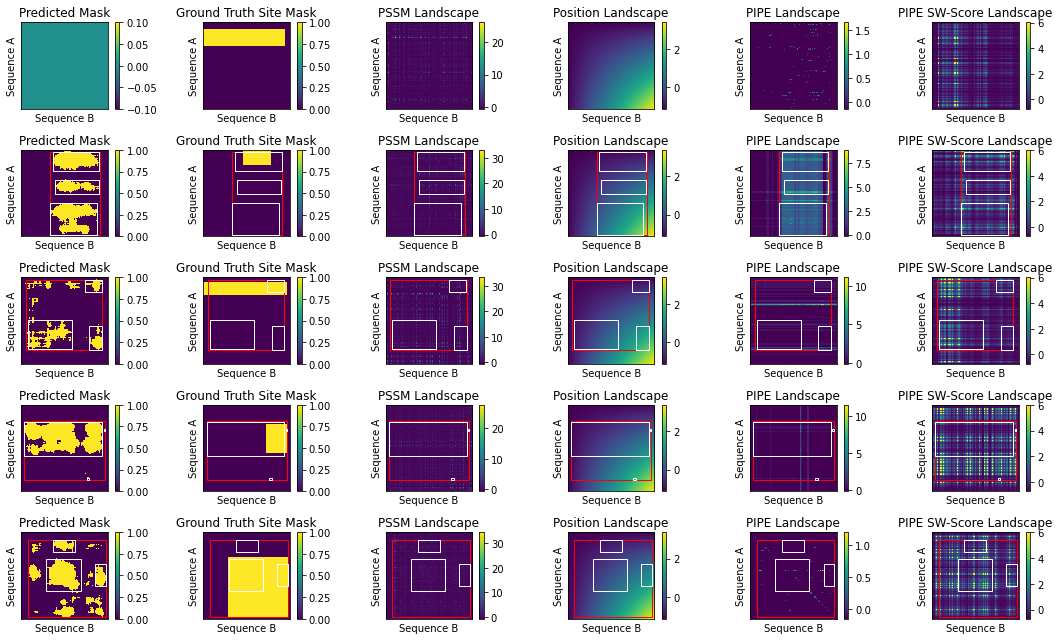

In [21]:
dataloader = test_dataloader
ncol = 6
nrows=5
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(15, 9))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)

        # calculate bounding boxes
        bbs_many = mask_to_box_many(pred[0,0,:,:].cpu().numpy().round().astype(int), max_label=3)
        bbs = mask_to_box(pred[0,0,:,:].cpu().numpy().round().astype(int), max_label=1)
#         bb25 = mask_to_box(pred[0,0,:,:], tail=0.25)
#         bb33 = mask_to_box(pred[0,0,:,:], tail=0.4)
        
        plot_mask(pred[0,0,:,:], ax[i][0], round=True, title="Predicted Mask", bbs=bbs, bbs2 = bbs_many)
        plot_mask(y[0,0,:,:], ax[i][1], title='Ground Truth Site Mask', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,0,:,:], ax[i][2], title='PSSM Landscape', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,1,:,:], ax[i][3], title='Position Landscape', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,2,:,:], ax[i][4], title='PIPE Landscape', bbs=bbs, bbs2 = bbs_many)
        plot_mask(x[0,3,:,:], ax[i][5], title='PIPE SW-Score Landscape', bbs=bbs, bbs2 = bbs_many)
        i+=1
        
plt.tight_layout()

# Function to compute the dice accuracy

In [22]:
def compute_acc(dataloader, model):
    acc = []
    loss = []
    jacc = []
    #model.eval()
    #with torch.no_grad():
    for _, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(bce_dice_loss(pred, y).item())
        # loss.append(BCELoss)    
        acc.append(dice_metric(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
        jacc.append(jaccard_index(pred.data.cpu().numpy().round(), y.data.cpu().numpy()))
       
    print(f'Loss: {np.mean(loss)}, Accuracy (dice): {np.mean(acc)}, Jaccard Index: {np.mean(jacc)}')

# Compute dice accuracy for train, validation and test data

In [23]:
compute_acc(test_dataloader, model)

Loss: 1.1034323945641518, Accuracy (dice): 0.3373917043209076, Jaccard Index: 0.23781706392765045


In [24]:
compute_acc(train_dataloader, model)

Loss: 1.101457493053958, Accuracy (dice): 0.35229089856147766, Jaccard Index: 0.2503175139427185


In [25]:
compute_acc(val_dataloader, model)

Loss: 1.0916847458907537, Accuracy (dice): 0.357963889837265, Jaccard Index: 0.2554086148738861


## Test totally random

In [26]:
model = UNet2D(n_class=sample[1].shape[0], n_channels=sample[0].shape[0])
model.cuda()
model.eval()
compute_acc(test_dataloader, model)

Loss: 1.437402578336852, Accuracy (dice): 0.1825532764196396, Jaccard Index: 0.10467003285884857


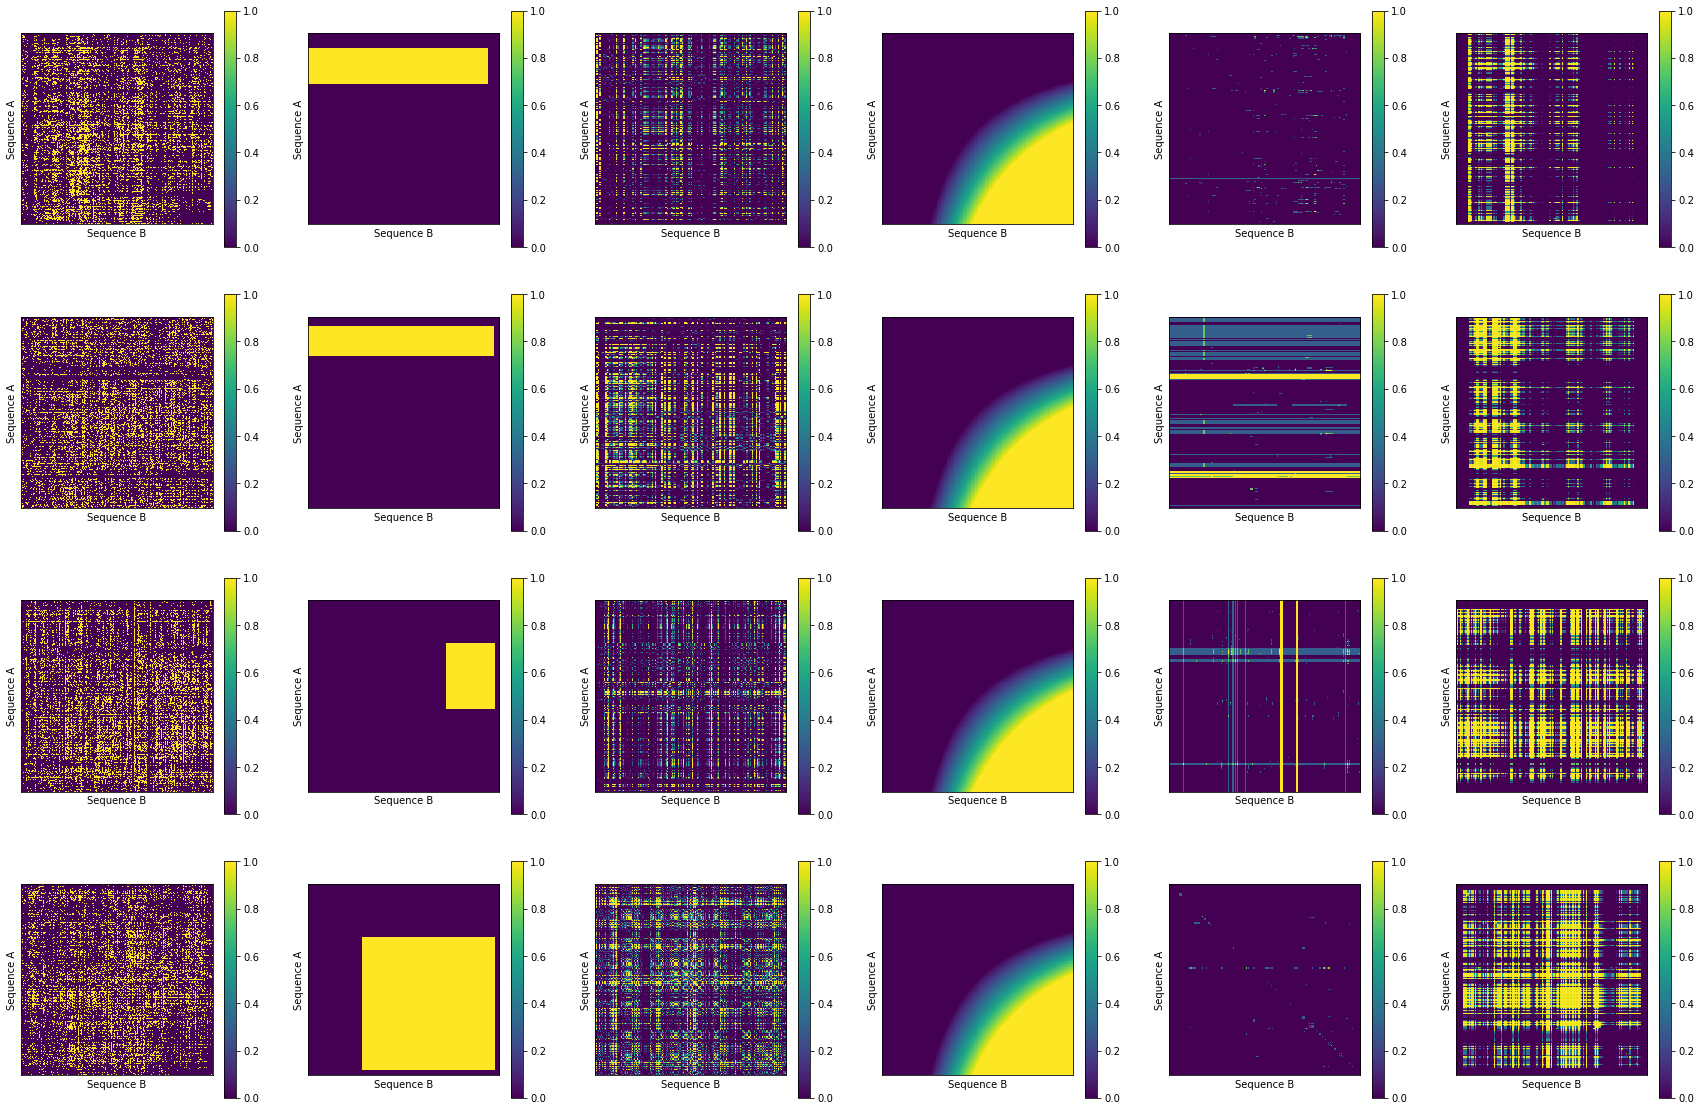

In [27]:
dataloader = test_dataloader
ncol = 6
nrows=4
random.seed(839)
rand_ndx = random.sample(range(0, len(dataloader)), nrows)
fig, ax = plt.subplots(nrows=nrows,  ncols=ncol, figsize=(30, 20))
i = 0
for n, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)
    if n in rand_ndx:
        pred = model.forward(x)
        plot_mask(pred[0,0,:,:], ax[i][0], round=True)
        plot_mask(y[0,0,:,:], ax[i][1])
        plot_mask(x[0,0,:,:], ax[i][2])
        plot_mask(x[0,1,:,:], ax[i][3])
        plot_mask(x[0,2,:,:], ax[i][4])
        plot_mask(x[0,3,:,:], ax[i][5])
        i+=1

# Convert to bounding boxes

Create dataset object that can take pair names

In [24]:
class DatasetBB(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, transform = None, normalize_transform = None, interp_size = 512):
        super(DatasetBB, self).__init__()
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.compose([
                transforms.Resize((interp_size, interp_size), interpolation=0)
            ])
        self.normalize_transform = None
        
        self.interp_size = interp_size
        self.img_files = glob.glob(os.path.join(folder_path,'features','*.npy'))
        self.mask_files = []
        self.pair_names = []
        for img_path in self.img_files:
            self.mask_files.append(os.path.join(folder_path,'masks',os.path.basename(img_path)) )
            self.pair_names.append(os.path.splitext(os.path.basename(img_path))[0])

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]

        data = np.load(img_path)
        label = np.load(mask_path)
        
        data = torch.from_numpy(data).float()
        label = torch.from_numpy(label).float()
        
        samp = torch.cat((data, label))
        
        samp = self.transform(samp)
        data = samp[:-1]
        label = samp[-1].unsqueeze(0)
        
        if self.normalize_transform:
            data = self.normalize_transform(data)
            

#         data = F.interpolate(data.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
#         label = F.interpolate(label.unsqueeze(0), (self.interp_size, self.interp_size)).squeeze(0)
        return data, label, self.pair_names[index]

    def __len__(self):
        return len(self.img_files)



In [25]:
ds_test = DatasetBB(os.path.join('data', dataset_dir, 'test'), transform=transform_dict['val'], normalize_transform=normalize_transform)
ds_val = DatasetBB(os.path.join('data', dataset_dir, 'val'), transform=transform_dict['val'], normalize_transform=normalize_transform)

In [26]:
ds_test.__getitem__(0)

(tensor([[[2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4737e-02, 2.4737e-02, 2.5345e-02,  ..., 3.2462e-02,
           3.2462e-02, 1.7099e-02],
          [2.4130e-02, 2.4130e-02, 2.6300e-02,  ..., 3.4546e-02,
           3.4546e-02, 1.7099e-02],
          ...,
          [1.6231e-02, 1.6231e-02, 1.6144e-02,  ..., 1.9096e-02,
           1.9096e-02, 3.3678e-02],
          [1.8054e-02, 1.8054e-02, 1.8835e-02,  ..., 2.8991e-02,
           2.8991e-02, 2.2073e-01],
          [1.5971e-02, 1.5971e-02, 1.5190e-02,  ..., 1.6318e-02,
           1.6318e-02, 2.6126e-02]],
 
         [[6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [6.2924e-06, 6.2924e-06, 1.2585e-05,  ..., 1.9507e-03,
           1.9507e-03, 1.9569e-03],
          [1.2585e-05, 1.2585e-05, 2.5170e-05,  ..., 3.9013e-03,
           3.9013e-03, 3.9139e-03],
          ...,
          [3.2028e-03, 3.2028e-03, 6.4057e-03,  ..., 9.928

In [27]:
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=1, num_workers=0, shuffle=False)
val_dl = torch.utils.data.DataLoader(ds_val, batch_size=1, num_workers=0, shuffle=False)

In [32]:
# data, mask, pairname = iter(test_dl).next()

In [33]:
# data.shape, mask.shape

In [34]:
# mask.to(device)

In [35]:
# pred = model(data.to(device))

In [36]:
# pred.shape

In [37]:
# torch.randn(2, 4).sum(0)

In [38]:
# cumsum_b = np.cumsum(pred.view(512,512).sum(0).cpu().numpy())
# cumsum_a = np.cumsum(pred.view(512,512).sum(1).cpu().numpy())

In [39]:
# tail=0.25
# np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail)), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail))

In [40]:
# plt.matshow(pred[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [41]:
# plt.matshow(mask[0,0,:,:].detach().cpu().numpy())
# plt.colorbar()

In [42]:
# def mask_to_box(mask, tail=0.0):
#     cumsum_b = np.cumsum(mask[0,0,:,:].max(0).cpu().numpy())
#     cumsum_a = np.cumsum(mask[0,0,:,:].max(1).cpu().numpy())
    
#     # right at beginning of range makes sure it searches for the first index not of the value
#     # left at end of range makes sure it searches for the last index of the value
#     range_a = (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))
#     range_b = (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))
#     return range_a, range_b

In [43]:
# cumsum_b = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=0)))
# cumsum_a = np.cumsum(np.round(pred[0,0,:,:].cpu().numpy().max(axis=1)))

In [44]:
# plt.plot(cumsum_b)

In [45]:
# plt.plot(cumsum_a)

In [46]:
# tail=0.20
# (np.searchsorted(cumsum_a, np.quantile(cumsum_a, tail), side='right'), np.searchsorted(cumsum_a, np.quantile(cumsum_a, 1-tail), side='left'))

In [47]:
# (np.searchsorted(cumsum_b, np.quantile(cumsum_b, tail), side='right'), np.searchsorted(cumsum_b, np.quantile(cumsum_b, 1-tail), side='left'))

In [48]:
# np.quantile(cumsum_a, tail)

In [49]:
# np.quantile(cumsum_b, tail)

In [50]:
# ndimage.find_objects(np.zeros((50,50), dtype=np.int), max_label=1)

In [51]:
# plt.matshow(pred[0,0,:,:].cpu().numpy().round().astype(int))

In [52]:
# mask_to_box(mask[0,0,:,:].cpu().numpy().round().astype(int))

## Get predictions and turn them into bounding boxes

In [28]:
checkpoint = torch.load(f'./models/{model_dir}/{dataset_dir}/best_model.pth',
                        map_location=torch.device('cpu'))

model = checkpoint['model']
model.cuda()
model.eval()
torch.set_grad_enabled(False)

top_n = 3
import pandas as pd


def get_predictions_to_bbs(dataloader, model, top_n):
    
    model.cuda()
    model.eval()
    torch.set_grad_enabled(False)
    
    bb_preds = []
    bb_preds_many = []
    bb_trues = []
    pairnames = []
    
    for _, (data, mask, pairname) in enumerate(dataloader):
        data, mask = data.to(device), mask.to(device)

        pred = model(data)

        pred = pred[0,0,:,:].cpu().numpy().round().astype(int)
        mask = mask[0,0,:,:].cpu().numpy().round().astype(int)
        

        bb_preds.append(mask_to_box(pred))
        bb_preds_many.append(mask_to_box_many(pred, max_label=top_n))
        bb_trues.append(mask_to_box(mask))
        pairnames.append(pairname)
        
#         plt.matshow(pred)
        
#         break
    
    return pd.DataFrame(list(zip(pairnames, bb_preds, bb_preds_many, bb_trues)), columns=['pair', 'pred', 'pred_many', 'true'])
    
test_df = get_predictions_to_bbs(test_dl, model, top_n)
val_df = get_predictions_to_bbs(val_dl, model, top_n)

In [29]:
test_df

,pair,pred,pred_many,true
0,"(P00830_P38077,)","[(slice(30, 426, None), slice(38, 494, None))]","[(slice(30, 90, None), slice(46, 102, None)), ...","[(slice(170, 389, None), slice(56, 511, None))]"
1,"(P06245_P05986,)","[(slice(94, 430, None), slice(122, 378, None))]","[(slice(94, 420, None), slice(122, 374, None))...","[(slice(93, 437, None), slice(112, 440, None))]"
2,"(P06780_P51862,)","[(slice(14, 434, None), slice(142, 498, None))]","[(slice(14, 316, None), slice(238, 374, None))...","[(slice(27, 454, None), slice(250, 319, None))]"
3,"(P06782_P38717,)","[(slice(38, 474, None), slice(38, 482, None))]","[(slice(38, 250, None), slice(354, 482, None))...","[(slice(44, 248, None), slice(129, 177, None))]"
4,"(P08018_P53599,)","[(slice(46, 498, None), slice(114, 498, None))]","[(slice(54, 92, None), slice(190, 210, None)),...","[(slice(276, 478, None), slice(411, 506, None))]"
...,...,...,...,...
106,"(Q12189_Q12189,)","[(slice(66, 498, None), slice(70, 494, None))]","[(slice(186, 358, None), slice(186, 352, None)...","[(slice(145, 499, None), slice(145, 499, None))]"
107,"(Q12223_Q12223,)","[(slice(58, 456, None), slice(62, 458, None))]","[(slice(94, 224, None), slice(132, 222, None))...","[(slice(99, 433, None), slice(99, 433, None))]"
108,"(Q12329_Q12329,)","[(slice(84, 461, None), slice(78, 466, None))]","[(slice(86, 222, None), slice(330, 462, None))...","[(slice(336, 487, None), slice(336, 487, None))]"
109,"(Q12438_Q12438,)","[(slice(44, 488, None), slice(42, 486, None))]","[(slice(44, 94, None), slice(414, 454, None)),...","[(slice(282, 428, None), slice(282, 428, None))]"


In [30]:
# -1 to make inclusive
deslice = lambda y: [((x[0].start, x[0].stop-1), (x[1].start, x[1].stop-1)) for x in y]

In [31]:
test_df[['pred', 'true', 'pred_many']] = test_df[['pred', 'true', 'pred_many']].applymap(deslice)
val_df[['pred', 'true', 'pred_many']] = val_df[['pred', 'true', 'pred_many']].applymap(deslice)

In [32]:
test_df

,pair,pred,pred_many,true
0,"(P00830_P38077,)","[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]"
1,"(P06245_P05986,)","[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]"
2,"(P06780_P51862,)","[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]"
3,"(P06782_P38717,)","[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]"
4,"(P08018_P53599,)","[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]"
...,...,...,...,...
106,"(Q12189_Q12189,)","[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]"
107,"(Q12223_Q12223,)","[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]"
108,"(Q12329_Q12329,)","[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]"
109,"(Q12438_Q12438,)","[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]"


Get lengths of proteins

In [33]:
protein_sequence = "data/uniprot-proteome_UP000002311_stripped.fasta"
protein_sequence_CD = pd.read_csv(protein_sequence, header = None, sep = "\t")
print("Loaded UniProt proteome")
new_df_ps = pd.DataFrame(index = protein_sequence_CD[0].iloc[::2].map(lambda x: str(x)[1:].strip()))
new_df_ps['Sequence'] = protein_sequence_CD[0].iloc[1::2].to_numpy()
new_df_ps['Length'] = new_df_ps['Sequence'].map(lambda x: len(x))
new_df_ps

Loaded UniProt proteome


,Sequence,Length
0,,
P21192,MDNVVDPWYINPSGFAKDTQDEEYVQHHDNVNPTIPPPDNYILNNE...,770
P46993,MTTLASSIEHKTKHLAAPFENDENPWMKKYCCQCKSCKMSVPVQPW...,209
P47117,MSYLNNPAVVMDNGTGLTKLGFAGNDSPSWVFPTAIATAAPSNTKK...,449
P22768,MSKGKVCLAYSGGLDTSVILAWLLDQGYEVVAFMANVGQEEDFDAA...,420
P29311,MSTSREDSVYLAKLAEQAERYEEMVENMKTVASSGQELSVEERNLL...,267
...,...,...
P47049,MYEMSGIDSLFHDRVVHDYSHTSEQVIVVYISSAAGDNSWLHQWFK...,396
P53142,MNRILSSASLLSNVSMPRQNKHKITKALCYAIIVASIGSIQFGYHL...,486
Q05919,MKRFLLSRRQRHLRMICFHNISLFRANGDSKLIKEYGDGFIPCFFI...,439


In [34]:
test_df['pair'] = test_df['pair'].apply(lambda x: x[0]).str.split(pat='_')
test_df

,pair,pred,pred_many,true
0,"[P00830, P38077]","[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]"
1,"[P06245, P05986]","[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]"
2,"[P06780, P51862]","[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]"
3,"[P06782, P38717]","[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]"
4,"[P08018, P53599]","[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]"
...,...,...,...,...
106,"[Q12189, Q12189]","[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]"
107,"[Q12223, Q12223]","[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]"
108,"[Q12329, Q12329]","[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]"
109,"[Q12438, Q12438]","[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]"


In [35]:
test_df[['protein_a', 'protein_b']] = pd.DataFrame(test_df['pair'].tolist(), index=test_df.index)
test_df.drop(['pair'], inplace=True, axis=1)
test_df

,pred,pred_many,true,protein_a,protein_b
0,"[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]",P00830,P38077
1,"[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]",P06245,P05986
2,"[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862
3,"[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]",P06782,P38717
4,"[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]",P08018,P53599
...,...,...,...,...,...
106,"[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]",Q12189,Q12189
107,"[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]",Q12223,Q12223
108,"[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]",Q12329,Q12329
109,"[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]",Q12438,Q12438


In [36]:
test_df['len_a'] = test_df['protein_a'].apply(lambda x: new_df_ps.Length.loc[x])
test_df['len_b'] = test_df['protein_b'].apply(lambda x: new_df_ps.Length.loc[x])
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b
0,"[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]",P00830,P38077,511,311
1,"[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398
2,"[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356
3,"[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]",P06782,P38717,633,1229
4,"[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]",P08018,P53599,668,1579
...,...,...,...,...,...,...,...
106,"[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258
107,"[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238
108,"[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375
109,"[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231


In [37]:
# Formula adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_dice_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb1 : list: [[y1, y2], [x1, x2]]
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    assert bb1[0][0] < bb1[0][1]
    assert bb1[1][0] < bb1[1][1]
    assert bb2[0][0] < bb2[0][1]
    assert bb2[1][0] < bb2[1][1]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[1][0], bb2[1][0])
    y_top = max(bb1[0][0], bb2[0][0])
    x_right = min(bb1[1][1], bb2[1][1])
    y_bottom = min(bb1[0][1], bb2[0][1])

    if x_right < x_left or y_bottom < y_top:
        return 0.0, 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

    # compute the area of both AABBs
    bb1_area = (bb1[1][1] - bb1[1][0] + 1) * (bb1[0][1] - bb1[0][0] + 1)
    bb2_area = (bb2[1][1] - bb2[1][0] + 1) * (bb2[0][1] - bb2[0][0] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    # dice
    dice =  2 * intersection_area / float(bb1_area + bb2_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou, dice

In [38]:
test_df['iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred[0], x.true[0]), axis=1)
test_df[['iou', 'dice']] = pd.DataFrame(test_df['iou_dice'].tolist(), index=test_df.index)
test_df.drop(['iou_dice'], inplace=True, axis=1)

val_df['iou_dice'] = val_df.apply(lambda x: get_dice_iou(x.pred[0], x.true[0]), axis=1)
val_df[['iou', 'dice']] = pd.DataFrame(val_df['iou_dice'].tolist(), index=val_df.index)
val_df.drop(['iou_dice'], inplace=True, axis=1)

In [39]:
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice
0,"[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.520469,0.684617
1,"[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.762337,0.865143
2,"[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.186103,0.313806
3,"[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050583,0.096295
4,"[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.100317,0.182343
...,...,...,...,...,...,...,...,...,...
106,"[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.664898,0.798725
107,"[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.707807,0.828907
108,"[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.106329,0.192220
109,"[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.108128,0.195155


In [40]:
val_df

,pair,pred,pred_many,true,iou,dice
0,"(O94742_P46674,)","[((92, 455), (90, 497))]","[((98, 117), (382, 409)), ((154, 453), (283, 4...","[((116, 477), (78, 197))]",0.236549,0.382596
1,"(P00546_P20486,)","[((62, 489), (42, 367))]","[((74, 379), (44, 367)), ((454, 489), (232, 27...","[((13, 506), (93, 354))]",0.715062,0.833861
2,"(P00830_P30902,)","[((38, 406), (38, 473))]","[((38, 77), (102, 129)), ((139, 403), (38, 241...","[((170, 388), (9, 464))]",0.559171,0.717267
3,"(P02829_P38080,)","[((14, 497), (10, 451))]","[((14, 175), (10, 153)), ((210, 497), (10, 157...","[((132, 509), (31, 146))]",0.197176,0.329402
4,"(P03069_P03069,)","[((77, 497), (86, 453))]","[((118, 253), (140, 253)), ((274, 433), (266, ...","[((407, 502), (407, 502))]",0.026753,0.052113
...,...,...,...,...,...,...
107,"(Q12241_P36015,)","[((46, 493), (22, 501))]","[((46, 105), (442, 489)), ((334, 493), (22, 50...","[((408, 502), (349, 504))]",0.060719,0.114487
108,"(Q12330_Q08963,)","[((54, 489), (86, 357))]","[((54, 353), (86, 357)), ((406, 489), (238, 34...","[((99, 501), (99, 389))]",0.752392,0.858703
109,"(Q12449_P53834,)","[((22, 481), (52, 445))]","[((46, 209), (318, 442)), ((331, 481), (318, 4...","[((18, 219), (41, 491))]",0.401441,0.572897
110,"(Q12460_P39990,)","[((44, 425), (46, 425))]","[((166, 237), (90, 233)), ((178, 423), (296, 4...","[((182, 420), (70, 455))]",0.558551,0.716756


## Distance Measure

The distance measure is as described in PIPE-Sites: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-225

In [41]:
def dm(pred, true, len_a, len_b):
    
    assert pred[0][0] < pred[0][1]
    assert pred[1][0] < pred[1][1]
    assert true[0][0] < true[0][1]
    assert true[1][0] < true[1][1]
    
    delta_a = max(true[0][0]-pred[0][0], pred[0][1]-true[0][1], 0)/len_a
    delta_b = max(true[1][0]-pred[1][0], pred[1][1]-true[1][1], 0)/len_b
    
    result = ((delta_a**2 + delta_b**2)**0.5)/(2**0.5)
    
    return result

In [42]:
test_df['dm'] = test_df.apply(lambda x: dm(x.pred[0], x.true[0], 512, 512), axis=1)
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice,dm
0,"[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.520469,0.684617,0.194941
1,"[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.762337,0.865143,0.000000
2,"[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.186103,0.313806,0.247862
3,"[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050583,0.096295,0.524262
4,"[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.100317,0.182343,0.518791
...,...,...,...,...,...,...,...,...,...,...
106,"[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.664898,0.798725,0.150441
107,"[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.707807,0.828907,0.076272
108,"[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.106329,0.192220,0.498081
109,"[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.108128,0.195155,0.466801


In [43]:
test_df[['iou', 'dice', 'dm']].describe()

,iou,dice,dm
count,111.000000,111.000000,111.000000
mean,0.259770,0.359565,0.392520
std,0.246787,0.276171,0.203273
min,0.000000,0.000000,0.000000
25%,0.071929,0.134197,0.264879
50%,0.185732,0.313279,0.404653
75%,0.368722,0.538783,0.517655
max,0.885706,0.939390,0.890659


## Best out of 3 distance measure

In [44]:
def best_dm_idx(preds, true, len_a, len_b):
    dms = np.asarray([dm(pred, true, len_a, len_b) for pred in preds])
    
    return dms.argmin()


test_df['best_dm_idx'] = test_df.apply(lambda x: best_dm_idx(x.pred_many, x.true[0], 512, 512), axis=1)

##
test_df['best_dm'] = test_df.apply(lambda x: dm(x.pred_many[x.best_dm_idx], x.true[0], 512, 512), axis=1)

test_df['best_iou_dice'] = test_df.apply(lambda x: get_dice_iou(x.pred_many[x.best_dm_idx], x.true[0]), axis=1)
test_df[['best_iou', 'best_dice']] = pd.DataFrame(test_df['best_iou_dice'].tolist(), index=test_df.index)
test_df.drop(['best_iou_dice'], inplace=True, axis=1)
test_df

,pred,pred_many,true,protein_a,protein_b,len_a,len_b,iou,dice,dm,best_dm_idx,best_dm,best_iou,best_dice
0,"[((30, 425), (38, 493))]","[((30, 89), (46, 101)), ((86, 373), (38, 265))...","[((170, 388), (56, 510))]",P00830,P38077,511,311,0.520469,0.684617,0.194941,2,0.000000,0.211952,0.349770
1,"[((94, 429), (122, 377))]","[((94, 419), (122, 373)), ((294, 305), (134, 1...","[((93, 436), (112, 439))]",P06245,P05986,380,398,0.762337,0.865143,0.000000,0,0.000000,0.728091,0.842654
2,"[((14, 433), (142, 497))]","[((14, 315), (238, 373)), ((14, 125), (378, 49...","[((27, 453), (250, 318))]",P06780,P51862,209,1356,0.186103,0.313806,0.247862,0,0.078052,0.394138,0.565421
3,"[((38, 473), (38, 481))]","[((38, 249), (354, 481)), ((42, 265), (38, 181...","[((44, 247), (129, 176))]",P06782,P38717,633,1229,0.050583,0.096295,0.524262,1,0.128112,0.303571,0.465753
4,"[((46, 497), (114, 497))]","[((54, 91), (190, 209)), ((268, 497), (122, 49...","[((276, 477), (411, 505))]",P08018,P53599,668,1579,0.100317,0.182343,0.518791,2,0.145012,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,"[((66, 497), (70, 493))]","[((186, 357), (186, 351)), ((234, 321), (434, ...","[((145, 498), (145, 498))]",Q12189,Q12189,258,258,0.664898,0.798725,0.150441,0,0.000000,0.227840,0.371123
107,"[((58, 455), (62, 457))]","[((94, 223), (132, 221)), ((258, 397), (258, 4...","[((99, 432), (99, 432))]",Q12223,Q12223,238,238,0.707807,0.828907,0.076272,1,0.000000,0.198286,0.330949
108,"[((84, 460), (78, 465))]","[((86, 221), (330, 461)), ((266, 445), (278, 4...","[((336, 486), (336, 486))]",Q12329,Q12329,375,375,0.106329,0.192220,0.498081,1,0.125548,0.337734,0.504935
109,"[((44, 487), (42, 485))]","[((44, 93), (414, 453)), ((250, 487), (246, 48...","[((282, 427), (282, 427))]",Q12438,Q12438,231,231,0.108128,0.195155,0.466801,1,0.115251,0.373179,0.543526


In [45]:
test_df.describe()

,len_a,len_b,iou,dice,dm,best_dm_idx,best_dm,best_iou,best_dice
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,530.837838,545.522523,0.259770,0.359565,0.392520,0.891892,0.121542,0.211324,0.299131
std,394.612135,426.982624,0.246787,0.276171,0.203273,0.824085,0.143262,0.221899,0.277800
min,70.000000,93.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,243.500000,227.000000,0.071929,0.134197,0.264879,0.000000,0.012430,0.005135,0.010209
50%,433.000000,393.000000,0.185732,0.313279,0.404653,1.000000,0.063529,0.128246,0.227336
75%,674.000000,701.500000,0.368722,0.538783,0.517655,2.000000,0.178952,0.375943,0.546445
max,1928.000000,1928.000000,0.885706,0.939390,0.890659,2.000000,0.662181,0.839510,0.912754
